In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [2]:
import tensorflow as tf
import requests

In [3]:
print(tf.test.gpu_device_name())

/device:GPU:0


2022-10-26 07:45:49.681502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 07:45:50.072434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 07:45:50.073307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 07:45:50.369669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [5]:
#1 Part 1: Set up the dataset
img_dir = "https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"
train_split = "train"
test_split = "test"
val_split = "val"
train_annotation_file = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/%s.json" %train_split
test_annotation_file = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/%s.json" %test_split
val_annotation_file = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/%s.json" %val_split
# print(annotation_file)

In [6]:
print(test_annotation_file)

https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/test.json


In [6]:
##3. Read the file to extract each dataset example with label

import requests

train_split = requests.get(train_annotation_file, allow_redirects=True)
train_data = train_split.json()
test_split = requests.get(test_annotation_file, allow_redirects=True)
test_data = test_split.json()
val_split = requests.get(val_annotation_file, allow_redirects=True)
val_data = val_split.json()

In [8]:
train_data[10]

{'image': 'VizWiz_train_00000010.jpg',
 'question': 'Is this.',
 'answers': [{'answer_confidence': 'maybe', 'answer': 'android phone'},
  {'answer_confidence': 'maybe', 'answer': 'cell phone'},
  {'answer_confidence': 'maybe', 'answer': 'cell phone'},
  {'answer_confidence': 'maybe', 'answer': 'cellphone'},
  {'answer_confidence': 'yes', 'answer': 'samsung phone'},
  {'answer_confidence': 'yes', 'answer': 'unanswerable'},
  {'answer_confidence': 'yes', 'answer': 'phone'},
  {'answer_confidence': 'yes', 'answer': 'smart phone'},
  {'answer_confidence': 'yes', 'answer': 'white smartphone'},
  {'answer_confidence': 'yes', 'answer': 'phone'}],
 'answer_type': 'other',
 'answerable': 1}

In [86]:
type(train_data)

list

In [7]:
# #making dfs

train_data = pd.DataFrame({"question": [train_data[i]['question'] for i in range(len(train_data))],
                      "answerable": [train_data[i]['answerable']for i in range(len(train_data))],
                      'image': [img_dir + train_data[i]['image'] for i in range(len(train_data))]})


test_data = pd.DataFrame({"question": [test_data[i]['question'] for i in range(len(test_data))],
                      'image': [img_dir + test_data[i]['image'] for i in range(len(test_data))]})
    


val_data = pd.DataFrame({"question": [val_data[i]['question'] for i in range(len(val_data))],
                      "answerable": [val_data[i]['answerable'] for i in range(len(val_data))],
                      'image': [img_dir + val_data[i]['image'] for i in range(len(val_data))]})


In [9]:
#changing text to lower case

train_data[['question']]= train_data[['question']].apply(lambda x: x.astype(str).str.lower())
test_data[['question']]= test_data[['question']].apply(lambda x: x.astype(str).str.lower())
val_data[['question']]= val_data[['question']].apply(lambda x: x.astype(str).str.lower())

In [11]:
test_data

#dealing with contracted words

import re

def cont(text):
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)

    return text


from tqdm import tqdm

quest = []
for question in tqdm(train_data['question'].values):
    que = cont(question) 
    quest.append(que.lower().strip())
    
t_quest = []
for question in tqdm(test_data['question'].values):
    que = cont(question) 
    t_quest.append(que.lower().strip())
    
v_quest = []
for question in tqdm(val_data['question'].values):
    que = cont(question) 
    v_quest.append(que.lower().strip())

train_data['question']=quest
test_data['question']=t_quest
val_data['question']=v_quest




100%|██████████| 4319/4319 [00:00<00:00, 94592.39it/s]


In [11]:
from keras.layers import TextVectorization
    
max_features,max_len=5000, 500

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=max_len)
vec_ques = tf.data.Dataset.from_tensor_slices(train_data['question'].append(val_data['question'])).batch(128)
vectorizer.adapt(vec_ques)

In [12]:
vocab_size=vectorizer.vocabulary_size()

In [13]:
vocab_size

4370

In [14]:
#getting data ready for modeling
train_data=train_data[0:1500]
test_data=test_data[0:1000]
val_data=val_data[0:600]

In [15]:
#converting train to integer
xtrain_ques = vectorizer(np.array([[x] for x in train_data['question']])).numpy()



In [16]:
#converting validation to integer 
xval_ques = vectorizer(np.array([[x] for x in val_data['question']])).numpy()



In [44]:
#converting testing to integer 
xtest_ques = vectorizer(np.array([[x] for x in test_data['question']])).numpy()

In [45]:
len(xtest_ques)

1000

In [21]:
from skimage import io

In [19]:
# getting images

def read_img(x):
    
    img_size = (224,224)
    dummy = []
    for i in range(len(x)):
        img = io.imread(x[i])
        img = tf.cast(img, tf.float32)
        img = tf.image.resize(img, img_size)
        dummy.append(img)
    return dummy
    

In [22]:
train_img = read_img(train_data.image)

In [23]:
val_img = read_img(val_data.image)

In [38]:
test_img = read_img(test_data.image)

In [27]:
len(val_img)

600

In [66]:
# train_image_df=pd.DataFrame({'img': [i for i in train_images]})

# count = 0
# for i in train_images:
#     train_image_df['img'].loc[len(train_image_df)] = i

In [75]:
# train_image_df.to_csv('imgs_pp.csv')`

In [32]:
# import tensorflow as tf
from tensorflow.python.keras import Sequential, layers, Input, Model
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Embedding, Dropout, LSTM,BatchNormalization

In [28]:
# Define CNN for Image Input
cnn_model_1 = Sequential()
cnn_model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
cnn_model_1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_model_1.add(Conv2D(256, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Flatten())

img_ip = Input(shape=(224, 224, 3))
encoded_img = cnn_model_1(img_ip)


embedding_layer = Embedding(vocab_size, 256)


ques_ip = Input(shape=(None,), dtype='int32')
embedded_ques = embedding_layer(ques_ip)
encoded_ques = LSTM(256)(embedded_ques)

# concat 2 models nd add dense layer with two ops

concat = keras.layers.concatenate([encoded_ques, encoded_img])
output = Dense(2, activation='softmax')(concat)
vqa_1 = Model(inputs=[img_ip, ques_ip], outputs=output)

vqa_1.summary()


vqa_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1118720     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256)          525312      embedding[0][0]                  
______________________________________________________________________________________________

In [40]:
# model 2
cnn_model_2 = Sequential()
cnn_model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
cnn_model_2.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_2.add(MaxPooling2D((2, 2)))
cnn_model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model_2.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_2.add(MaxPooling2D((2, 2)))
cnn_model_2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_model_2.add(Conv2D(256, (3, 3), activation='relu'))
cnn_model_2.add(MaxPooling2D((2, 2)))
cnn_model_2.add(Flatten())

img_ip = Input(shape=(224, 224, 3))
encoded_img = cnn_model_2(img_ip)


embedding_layer = Embedding(vocab_size, 256)



ques_ip = Input(shape=(None,), dtype='int32')
embedded_ques = embedding_layer(ques_ip)
encoded_ques = LSTM(256)(embedded_ques)
encoded_ques = LSTM(256)(embedded_ques)
encoded_ques = LSTM(512)(embedded_ques)
encoded_ques = LSTM(512)(embedded_ques)


# concat 2 models nd add dense layer with two ops

concat = keras.layers.concatenate([encoded_ques, encoded_img])
output = Dense(2, activation='softmax')(concat)
vqa_2 = Model(inputs=[img_ip, ques_ip], outputs=output)

vqa_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1118720     input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 512)          1574912     embedding_2[0][0]                
____________________________________________________________________________________________

In [33]:
#model 3 

cnn_model_3 = Sequential()
cnn_model_3.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
cnn_model_3.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D((2, 2)))
cnn_model_3.add(Dropout(0.1))
cnn_model_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model_3.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D((2, 2)))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_model_3.add(Conv2D(256, (3, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D((2, 2)))
cnn_model_3.add(Flatten())

img_ip = Input(shape=(224, 224, 3))
encoded_img = cnn_model_3(img_ip)


embedding_layer = Embedding(vocab_size, 256)



ques_ip = Input(shape=(None,), dtype='int32')
embedded_ques = embedding_layer(ques_ip)
encoded_ques = LSTM(256)(embedded_ques)
encoded_ques = LSTM(512)(embedded_ques)
encoded_ques = LSTM(256)(embedded_ques)
encoded_ques = LSTM(512)(embedded_ques)
encoded_ques = LSTM(256)(embedded_ques)
encoded_ques = LSTM(512)(embedded_ques)



# concat 2 models nd add dense layer with binary ops

concat = keras.layers.concatenate([encoded_ques, encoded_img])
output = Dense(2, activation='softmax')(concat)
vqa_3 = Model(inputs=[img_ip, ques_ip], outputs=output)

printvqa_3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1118720     input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 512)          1574912     embedding_1[0][0]                
____________________________________________________________________________________________

In [29]:
#model 1

with tf.device('/GPU:0'):
    history_1 = vqa_1.fit([np.asarray(train_img), np.asarray(xtrain_ques)] , train_data["answerable"], epochs = 5, validation_data=([np.asarray(val_img), np.asarray(xval_ques)],val_data['answerable']))

2022-10-26 08:09:26.455255: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 903168000 exceeds 10% of free system memory.
2022-10-26 08:09:27.505921: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 903168000 exceeds 10% of free system memory.


Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-10-26 08:09:33.034091: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 198s 4s/step - loss: 46.3036 - accuracy: 0.6373 - val_loss: 0.7654 - val_accuracy: 0.5500
Epoch 2/5
47/47 [==============================] - 169s 4s/step - loss: 0.5888 - accuracy: 0.7100 - val_loss: 0.7004 - val_accuracy: 0.5500
Epoch 3/5
47/47 [==============================] - 169s 4s/step - loss: 0.5638 - accuracy: 0.7093 - val_loss: 0.8480 - val_accuracy: 0.5450
Epoch 4/5
47/47 [==============================] - 168s 4s/step - loss: 0.5320 - accuracy: 0.7247 - val_loss: 0.8152 - val_accuracy: 0.5683
Epoch 5/5
47/47 [==============================] - 177s 4s/step - loss: 0.4704 - accuracy: 0.7460 - val_loss: 0.7621 - val_accuracy: 0.5950


In [41]:
#model 2

vqa_model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])

with tf.device('/GPU:1'):
    history_2 = vqa_2.fit([np.asarray(train_img), np.asarray(xtrain_ques)] , train_data["answerable"], epochs = 5, validation_data=([np.asarray(val_img), np.asarray(xval_ques)],val_data['answerable']))
        

Epoch 1/5
47/47 [==============================] - 215s 5s/step - loss: 4.7355 - accuracy: 0.6587 - val_loss: 0.7029 - val_accuracy: 0.4467
Epoch 2/5
47/47 [==============================] - 204s 4s/step - loss: 0.6142 - accuracy: 0.6967 - val_loss: 0.7039 - val_accuracy: 0.5500
Epoch 3/5
47/47 [==============================] - 197s 4s/step - loss: 0.5978 - accuracy: 0.7087 - val_loss: 0.7523 - val_accuracy: 0.5467
Epoch 4/5
47/47 [==============================] - 198s 4s/step - loss: 0.5904 - accuracy: 0.7140 - val_loss: 0.8536 - val_accuracy: 0.5500
Epoch 5/5
47/47 [==============================] - 199s 4s/step - loss: 0.5406 - accuracy: 0.7273 - val_loss: 0.9560 - val_accuracy: 0.5367


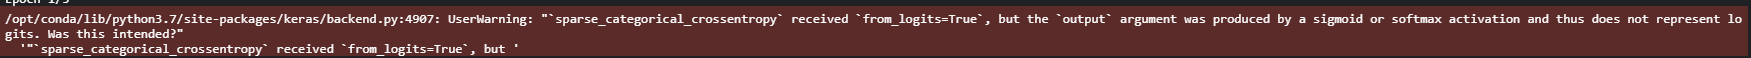

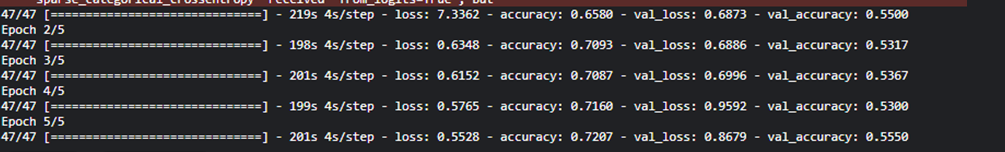


In [35]:
#model 3

vqa_model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_3 = vqa_3.fit([np.asarray(train_img), np.asarray(xtrain_ques)] , train_data["answerable"], epochs = 5, validation_data=([np.asarray(val_img), np.asarray(xval_ques)],val_data['answerable']))
        

2022-10-26 08:29:59.230936: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 903168000 exceeds 10% of free system memory.


Epoch 1/5


2022-10-26 08:30:04.695642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 172s 3s/step - loss: 0.8886 - accuracy: 0.6940 - val_loss: 0.7278 - val_accuracy: 0.5500
Epoch 2/5
47/47 [==============================] - 154s 3s/step - loss: 0.6053 - accuracy: 0.7100 - val_loss: 0.7447 - val_accuracy: 0.5500
Epoch 3/5
47/47 [==============================] - 165s 4s/step - loss: 0.6041 - accuracy: 0.7100 - val_loss: 0.7514 - val_accuracy: 0.5500
Epoch 4/5
47/47 [==============================] - 153s 3s/step - loss: 0.6042 - accuracy: 0.7100 - val_loss: 0.7385 - val_accuracy: 0.5500
Epoch 5/5
47/47 [==============================] - 155s 3s/step - loss: 0.6035 - accuracy: 0.7100 - val_loss: 0.7818 - val_accuracy: 0.5500


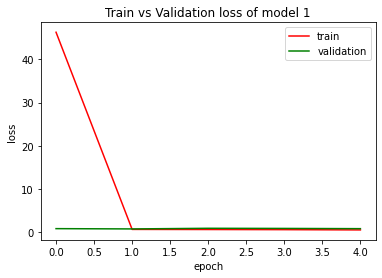

In [68]:
# model 1 loss
import matplotlib.pyplot as plt


plt.plot(history_1.history['loss'],color = "red")
plt.plot(history_1.history['val_loss'],color = "green")
plt.title('Train vs Validation loss of model 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

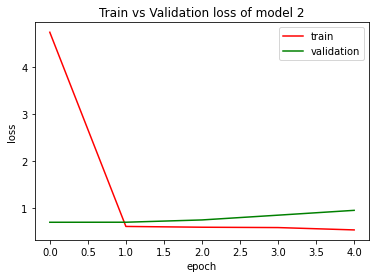

In [69]:
# model 2 loss
import matplotlib.pyplot as plt


plt.plot(history_2.history['loss'],color = "red")
plt.plot(history_2.history['val_loss'],color = "green")
plt.title('Train vs Validation loss of model 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

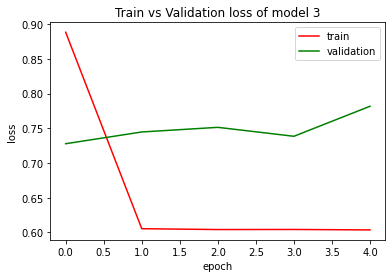

In [70]:
# model 3 loss
import matplotlib.pyplot as plt


plt.plot(history_3.history['loss'], color = "red")
plt.plot(history_3.history['val_loss'],color = "green")
plt.title('Train vs Validation loss of model 3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score


val_pred_1 = vqa_1.predict([np.asarray(val_im), np.asarray(xval_ques)])
val_pred_2 = vqa_2.predict([np.asarray(val_images), np.asarray(xval_ques)])
val_pred_3 = vqa_3.predict([np.asarray(val_images), np.asarray(xval_ques)])


empty_1=[]
for i in val_pred_1:
    empty_1.append([0 if i[0] > i[1] else 1])
empty_2 = []
for i in val_pred_2:
    empty_2.append([0 if i[0] > i[1] else 1])
empty_3 = []
for i in val_pred_3:
    empty_3.append([0 if i[0] > i[1] else 1])
    
    
    
##Evaluating results based on the VQA answerability metric
#All answers
gtlist = val_data["answerable"]

average_precision_1 = average_precision_score(gtlist, empty_1)
average_precision_2 = average_precision_score(gtlist, empty_2)
average_precision_3 = average_precision_score(gtlist, empty_3)

print("AP for vqmodel1: {}".format(round(100*average_precision_1, 5)))
print("AP for vqmodel2: {}".format(round(100*average_precision_2, 5)))
print("AP for vqmodel3: {}".format(round(100*average_precision_3, 5)))

In [73]:
from sklearn.metrics import average_precision_score


val_pred_1 = vqa_1.predict([np.asarray(val_img), np.asarray(xval_ques)])
val_pred_2 = vqa_2.predict([np.asarray(val_img), np.asarray(xval_ques)])
val_pred_3 = vqa_3.predict([np.asarray(val_img), np.asarray(xval_ques)])


empty_1=[]
for i in val_pred_1:
    empty_1.append([0 if i[0] > i[1] else 1])
empty_2 = []
for i in val_pred_2:
    empty_2.append([0 if i[0] > i[1] else 1])
empty_3 = []
for i in val_pred_3:
    empty_3.append([0 if i[0] > i[1] else 1])
    
    
    
##Evaluating results based on the VQA answerability metric
#All answers
gtlist = val_data["answerable"]

average_precision_1 = average_precision_score(gtlist, empty_1)
average_precision_2 = average_precision_score(gtlist, empty_2)
average_precision_3 = average_precision_score(gtlist, empty_3)

print("Average Precision for VQA model 1: {}".format(round(100*average_precision_1, 4)))
print("Average Precision for VQA model 2: {}".format(round(100*average_precision_2, 4)))
print("Average Precision for VQA model 3: {}".format(round(100*average_precision_3, 4)))

Average Precision for VQA model 1: 58.6218
Average Precision for VQA model 2: 54.4883
Average Precision for VQA model 3: 55.0


In [46]:
preds = vqa_1.predict([np.asarray(test_img), np.asarray(xtest_ques)])

In [51]:
result=[]
for i in preds:
    result.append([0 if i[0] > i[1] else 1])
    
    
results= pd.DataFrame(result)

In [54]:
results.to_csv('results.csv', index= False)

In [53]:
# tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [58]:
# results.value_counts()

1    822
0    178
dtype: int64